In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implementing a few more expressions

In [8]:
class Value:
    """
    A class that tracks a value and its gradient for automatic differentiation.
    This is a scalar-valued node in our computation graph.
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value node in the computation graph.
        
        Args:
            data: The actual value being tracked
            _children: Other Value objects that were used to create this one
            _op: The operation that produced this value (for visualization)
            label: Optional label for debugging
        """
        self.data = data                # The actual value being tracked
        
        self.grad = 0.0                 # Gradient of the final output with respect to this value
        self._backward = lambda: None   # Function to compute this node's gradient contribution. By default does nothing
        
        self._prev = set(_children)     # Set of Value objects that were used to create this one
        self._op = _op                  # The operation that created this Value ('+', '*', etc.)
        
        self.label = label              # Optional label for debugging

    def __repr__(self):
        """
        Provides nicer string representation of the Value object
        The thing it shows when you print()
        """
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
        Addition operation between two Value objects.
        Implements the chain rule for backpropagation.

        In Python, + --> __add__()
        """
        
        other = other if isinstance(other, Value) else Value(other)  # Convert scalar to Value if needed
        out = Value(self.data + other.data, (self, other), '+')
        #           (data, children, op)

        def _backward():
            # During backprop, add the gradient of the output to both inputs
            # ∂(a+b)/∂a = 1.0 and ∂(a+b)/∂b = 1.0
            #🚗 travels 3 times as fast as 🚲. 🚲 travels 4 times as fast as 🚶‍♂️. 🚗 = 3 × 4 = 12 times as fast as 🚶‍♂️
            self.grad += 1.0 * out.grad    # Chain rule: local gradient * upstream gradient
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        """
        Multiplication operation between two Value objects.
        Implements the chain rule for backpropagation.

        In Python, * --> __mul__()
        """
        other = other if isinstance(other, Value) else Value(other)  # Convert scalar to Value if needed
        out = Value(self.data * other.data, (self, other), '*')
                #           (data, children, op)

        
        def _backward():
            # During backprop, add the weighted gradients
            # ∂(a*b)/∂a = b and ∂(a*b)/∂b = a
            self.grad += other.data * out.grad   # Chain rule: local gradient * upstream gradient
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
    
    def tanh(self):
        """
        Hyperbolic tangent activation function.
        Implements the chain rule for backpropagation.
        """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Derivative of tanh(x) is 1 - tanh²(x)
            self.grad += (1 - t**2) * out.grad   # Chain rule: local gradient * upstream gradient
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        """
        Power operation: self ** other
        Currently only supports integer and float exponents.
        
        Implements gradient computation using chain rule:
        ∂(x^n)/∂x = n * x^(n-1)
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): return self * other  # If python doesnt know how to do 2*a, check if in a there is an __rmul__(a*2). This allows 2*a
    def __truediv__(self, other): return self * other**-1  # self / other--> a/b = a*1/b = a*b**-1
    def __neg__(self): return self * -1  # -self
    def __sub__(self, other): return self + (-other)  # self - other
    def __radd__(self, other): return self + other  # other + self

    
    def exp(self):
        """
        Exponential function (e^x).
        
        Implements gradient computation using chain rule:
        ∂exp(x)/∂x = exp(x)
        """
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad  # Chain rule with exp derivative
            #∂exp(x)/∂x = exp(x)

        out._backward = _backward
        
        return out
    
    def backward(self):
        """
        Runs backpropagation to compute gradients of all nodes in the graph.
        Uses topological sort to process nodes in the correct order.
        """
        
        # Build topological ordering of all nodes in the graph
        topo = []
        visited = set()
        def build_topo(v):
            """Recursive helper function to build topological ordering"""
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go through the nodes in reverse order
        self.grad = 1.0    # Initialize output gradient as 1.0
        for node in reversed(topo):
            node._backward()    # Compute gradient contributions

In [9]:
from graphviz import Digraph
#https://graphviz.org/

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Testing that $ \tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1} $

In [ ]:
#tanh


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'



o = n.tanh(); o.label = 'o'




o.backward()

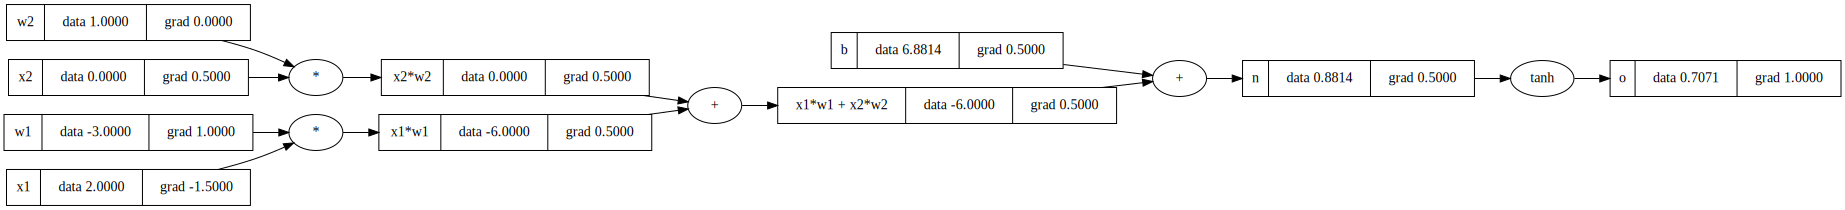

In [11]:
draw_dot(o)


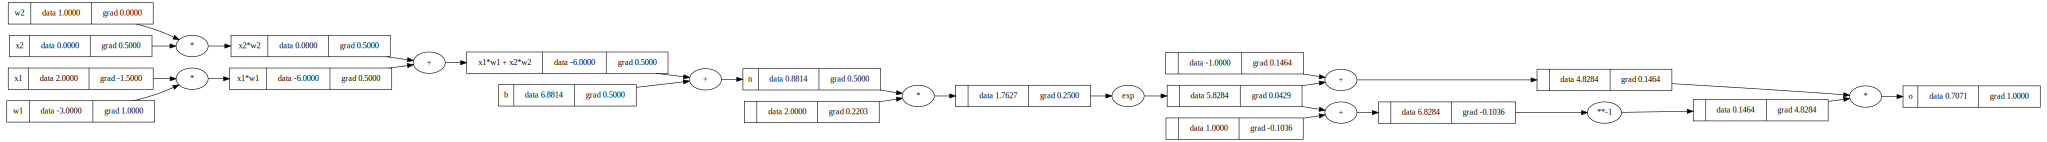

In [12]:
#e2x-1/e2x+1


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'



e = (2*n).exp()#e2x
o = (e - 1) / (e + 1)
o.label = 'o'




o.backward()
draw_dot(o)